In [42]:
from config_file import get_config

cfg = get_config()
cfg['batch_size'] = 128
cfg['preload'] = None
cfg['num_epochs'] = 20

from d import BilingualDataModule
from model import build_transformer
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, ModelSummary

In [43]:
datamodule = BilingualDataModule(cfg)
datamodule.setup()

Max length of source sentences: 43
Max length of target sentences: 38


In [44]:
model = build_transformer(
    datamodule.tokenizer_src.get_vocab_size(),
    datamodule.tokenizer_tgt.get_vocab_size(),
    cfg["seq_len"],
    cfg["seq_len"],
    d_model=cfg["d_model"],
)

In [45]:
trainer = pl.Trainer(
    max_epochs=cfg["num_epochs"],
    accelerator="cuda",
    callbacks=[
        ModelCheckpoint(dirpath=cfg['model_folder'], verbose=True,),
        LearningRateMonitor(logging_interval='step', log_momentum=True),
        ModelSummary(max_depth=0)
    ],
    default_root_dir="Store/",
    fast_dev_run=False,
    check_val_every_n_epoch=2,
    num_sanity_val_steps=10,
    limit_val_batches=1000,
    precision="16-mixed",
    gradient_clip_val=0.5,
    detect_anomaly=False
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [32]:
from pytorch_lightning.tuner import Tuner

tuner = Tuner(trainer=trainer)
lr_finder = tuner.lr_find(model,datamodule=datamodule, min_lr=1e-4, max_lr=1, num_training=trainer.max_epochs)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Max length of source sentences: 43
Max length of target sentences: 38


Finding best initial lr:   0%|          | 0/40 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=40` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.00199526231496888
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at Store/.lr_find_99d3f0f0-b57b-4d05-b01e-4def1173470b.ckpt


EPOCH: 0, Loss: nan


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at Store/.lr_find_99d3f0f0-b57b-4d05-b01e-4def1173470b.ckpt


new_lr=0.00199526231496888


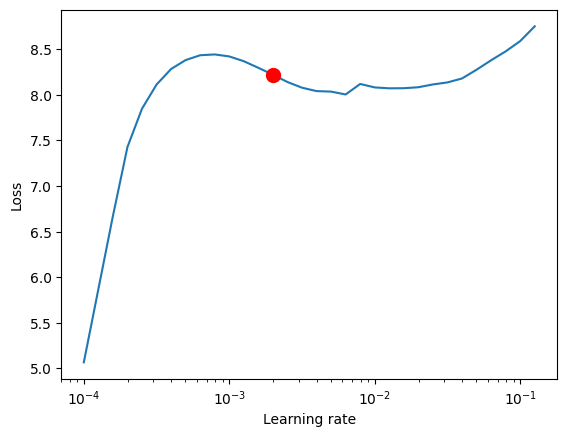

In [33]:
fig = lr_finder.plot(suggest=True)
fig.show()
new_lr = lr_finder.suggestion()
print(f"{new_lr=}")

In [46]:
new_lr=0.00199526231496888
model.best_lr = new_lr

In [47]:
trainer.fit(model, datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Max length of source sentences: 43
Max length of target sentences: 38


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: If he were to kill me, and if he were to kill Vronsky, I should respect him.
TARGET: Uccidesse me, uccidesse Vronskij, lo stimerei.
PREDICTED: appassionatamente malinconicamente mangiarli mangiarli mangiarli mangiarli mangiarli mangiarli mangiarli mangiarli Ricordatevi mangiarli Ricordatevi mangiarli Ricordatevi mangiarli Ricordatevi mangiarli Ricordatevi Ove Ricordatevi Ove Ricordatevi Ricordatevi Ricordatevi mangiarli Ricordatevi mangiarli Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Natalie supponete supponete Ove mangiarli Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi gioielli Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi improntati improntati Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi Ricordatevi impronta

Training: |          | 0/? [00:00<?, ?it/s]

EPOCH: 0, Loss: 7.524635314941406


Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: "How do you know?--you never tried it.
TARGET: — Che cosa ne sapete? Non l'avete mai gustato.
PREDICTED: — E che non è detto .
--------------------------------------------------------------------------------
SOURCE: This was hardly what I intended.
TARGET: Veramente io non la intendevo così.
PREDICTED: Ma non lo era .
--------------------------------------------------------------------------------
SOURCE: 'After all, how inclined we all are to these cruel spectacles,' he said. 'I notice...'
TARGET: — Ma come siamo tutti inclini a questi spettacoli feroci — disse. — Io noto....
PREDICTED: — E , — disse Levin , — disse Levin .
--------------------------------------------------------------------------------
SOURCE: And the worst thing about it is, that it's all my own fault – my own fault; and yet I'm not guilty!
TARGET: E quel ch’è peggio è che la colpa di tutto è mia... la colpa è mia, eppure non so

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: She met all his efforts to bring about an explanation by presenting an impenetrable wall of merry perplexity.
TARGET: A tutti i tentativi per portarla ad una spiegazione, ella opponeva il muro impenetrabile del suo allegro stupore.
PREDICTED: Era un momento , che era un momento , che era stato più di nuovo , che era stato più più di nuovo .
--------------------------------------------------------------------------------
SOURCE: 'And if he should refuse, who will stand?' asked Levin, looking at Vronsky.
TARGET: — E se rifiuterà, chi entrerà in ballottaggio? — domandò Levin, guardando Vronskij.
PREDICTED: — E che è ? — disse Levin , sorridendo , sorridendo , sorridendo , sorridendo , sorridendo , sorridendo , sorridendo , sorridendo , sorridendo .
--------------------------------------------------------------------------------
SOURCE: "No dust, no canvas coverings: except that the air feels chilly, o

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: 'I'll put a stop to this,' she said to herself, and shouted out, 'You'd better not do that again!' which produced another dead silence.
TARGET: “Bisogna finirla!” — pensò Alice, e strillò: — Non vi provate più! — Successe di nuovo un silenzio di tomba.
PREDICTED: — Sì , ma io mi , — disse , — e mi , come è un ’ altra cosa .
--------------------------------------------------------------------------------
SOURCE: "A true Janian reply! Good angels be my guard!
TARGET: — È una risposta degna di Jane!
PREDICTED: — , signore , signore .
--------------------------------------------------------------------------------
SOURCE: But afterwards the Princess also noticed that, apart from this infatuation, a serious spiritual change was taking place in her daughter.
TARGET: Ma in seguito la principessa notò che nella figlia, a parte questo incantamento, si compiva una vera trasformazione spirituale.
PREDICTED: M

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: Then addressing Mason, he inquired gently, "Are you aware, sir, whether or not this gentleman's wife is still living?"
TARGET: Poi rivolgendosi a Mason, gli domandò cortesemente: — Siete certo che la moglie del signor Rochester, viva?
PREDICTED: — Ebbene , non avete mai mai mai mai mai mai mai mai ? — disse , e non sapendo che cosa era il suo .
--------------------------------------------------------------------------------
SOURCE: But Levin could not sit still.
TARGET: Levin non poteva stare seduto.
PREDICTED: Levin non si interessava .
--------------------------------------------------------------------------------
SOURCE: 'Don't you know that you are all my life to me?...
TARGET: — Non sapete forse che siete per me tutta la vita?
PREDICTED: — Non vi dispiace di non posso dire che non mi sia di voi .
--------------------------------------------------------------------------------
SOURCE: He consi

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: 'And when is the ball to be?' said Anna, turning to Kitty.
TARGET: — E così ora, a quando un ballo? — ella disse rivolta a Kitty.
PREDICTED: — E che cosa ha detto qualcosa di Anna ? — disse Anna .
--------------------------------------------------------------------------------
SOURCE: He examined my face, I thought, with austerity, as I came near: the traces of tears were doubtless very visible upon it.
TARGET: Mi parve che Saint-John mi esaminasse austeramente; egli aveva veduto nel mio viso le traccie delle lagrime.
PREDICTED: un po ’ di , ma poi mi un tratto di un tratto .
--------------------------------------------------------------------------------
SOURCE: He recommenced his walk, but soon again stopped, and this time just before me.
TARGET: Egli riprese a camminare, ma subito si fermò davanti a me.
PREDICTED: Egli si voltò e , ma , senza dir qualcosa , ma non si .
--------------------------

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: My father said nothing about her money; but he told me Miss Mason was the boast of Spanish Town for her beauty: and this was no lie.
TARGET: Mio padre non mi parlò della dote, ma mi disse che la signorina Mason era l'orgoglio della città spagnuola, per la sua bellezza, ed era vero.
PREDICTED: Egli non voleva dire che la sua testa , ma non aveva coscienza di un ’ altra cosa , ma di lui , ma raffinato di lui era un ’ altra .
--------------------------------------------------------------------------------
SOURCE: CHAPTER I
TARGET: I
PREDICTED: I
--------------------------------------------------------------------------------
SOURCE: 'It is old... But, do you know, when you have once grasped it clearly, everything becomes so insignificant!
TARGET: — È vecchio; ma quando lo capisci chiaramente, allora tutto, in un certo modo si riduce a niente.
PREDICTED: — Ma ecco , ecco , domandate a volte , che non è

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: The week before, Kitty had repeated to her mother a conversation she had had with Vronsky while dancing the mazurka with him.
TARGET: La settimana prima Kitty aveva raccontato alla madre la sua conversazione con Vronskij durante una mazurca.
PREDICTED: La principessa Varvara , invece , invece di Kitty , invece , invece , invece , invece , invece , era stata più grande .
--------------------------------------------------------------------------------
SOURCE: 'Yes, it's he!
TARGET: — Ma è proprio lui!
PREDICTED: — Già , è arrivato .
--------------------------------------------------------------------------------
SOURCE: "Then I will say nothing, and you shall judge for yourself, sir."
TARGET: — Allora, signore, io tacerò e voi giudicherete.
PREDICTED: — Allora , signore , e io non riesco a .
--------------------------------------------------------------------------------
SOURCE: To me he was always r

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: 'Really – what does he drink?'
TARGET: — E che cosa beve?
PREDICTED: — E perché mai ?
--------------------------------------------------------------------------------
SOURCE: "I'll see it carried into your room," she said, and bustled out.
TARGET: Lo farò mettere in camera vostra. — disse, e uscì.
PREDICTED: — Sì , — disse , — e io sono stato un assassino , e io stesso .
--------------------------------------------------------------------------------
SOURCE: 'It will never be done with Russians!
TARGET: — Ciò non avverrà mai col popolo russo!
PREDICTED: — E non si può essere !
--------------------------------------------------------------------------------
SOURCE: 'Perhaps you would not if you were not successful,' said Vronsky.
TARGET: — Forse non lo confesseresti, se non avessi successo — disse Vronskij.
PREDICTED: — Non capisco , ma non è vero ? — disse Vronskij .
EPOCH: 15, CER: 0.9958809614181

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: But while walking over the meadow he recalled the impression mowing had made on him, and almost made up his mind to do it.
TARGET: Ma, camminando per il prato, ricordando le impressioni della falciatura, aveva deciso di falciare.
PREDICTED: Ma , pur avendo stima e vide che , avendo notato che gli era indispensabile fare la sua età .
--------------------------------------------------------------------------------
SOURCE: But all this did not seem dreadful, but amusing.
TARGET: Eppure tutto questo non era terribile, ma esilarante.
PREDICTED: Ma non si interessava di più , ma non si poteva .
--------------------------------------------------------------------------------
SOURCE: Mastering some hesitation, he answered, "Miss Oliver, I presume."
TARGET: Dominando l'emozione, rispose: — Alla signorina Oliver.
PREDICTED: — Sì , — risposi , — che mi abbia detto .
-------------------------------------------

Validation: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
SOURCE: 'My dear friend!' Lydia Ivanovna said once more.
TARGET: — Amico mio! — ripeteva Lidija Ivanovna.
PREDICTED: — Ah , è un uomo — disse il Re , —
--------------------------------------------------------------------------------
SOURCE: 'Yes, do come!' said Dolly. 'We shall expect you at five or six, just as you like.
TARGET: — Così, vi prego, venite — disse Dolly — noi vi aspettiamo alle cinque, alle sei se volete.
PREDICTED: — Sì , sì , sì , se aveste , se , se , se , se ne .
--------------------------------------------------------------------------------
SOURCE: 'But if I have seen it myself?'
TARGET: — Ma se ho visto con i miei occhi?
PREDICTED: — Ma che cosa mai ho fatto ?
--------------------------------------------------------------------------------
SOURCE: "I have formed no supposition on the subject, sir; but I want to go on as usual for another month."
TARGET: — Non ho fatto una supposizione

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


EPOCH: 19, Loss: 3.198716640472412
